In [4]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 20 09:59:24 2021

@author: leona
"""
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np

#Realiza a detecação e descrição dos keypoints da imagem Utilizando O SIFT
def extractsift(img):
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(img,None)
    
    return (kp, des)

#Realiza a detecação dos keypoints da imagem utilizando o SIFT e
#a descrição dos keypoints utilizando o Brief
def extractbrief(img):
    brief = cv.xfeatures2d.BriefDescriptorExtractor_create()
    kp, _ = extractsift(img)
    kp, des = brief.compute(img, kp)
    return (kp, des)

#Encontra os Match dos keypoints na imagem 1 com a imagem 2
def matches(src_des, dst_des):
    bf = cv.BFMatcher_create()
    matches = bf.knnMatch(src_des,dst_des, k=2)
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m) 
    return good

#Realiza a Homografia
def homografy(good, src_kp, dst_kp):
    src_pts = np.float32([ src_kp[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ dst_kp[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC,3.0)
    return M, mask

#Realiza o Warp e o blind, se for 1 retornar a average e se for dois
#retorna a Feathering:
def warp(dst_img, src_img, M, blend):
    dst_w, dst_h, _ = dst_img.shape
    src_w, src_h, _ = src_img.shape
    
    warp_dst = cv.warpPerspective(dst_img, M, (src_h*2, src_w*2))   
    
    if blend == 0:
        warp_dst[0:src_img.shape[0], 0:src_img.shape[1]] = src_img
         
    warp_dst = np.float32(warp_dst)
    src_img = np.float32(src_img)
    warp_w, warp_h, _ = warp_dst.shape    
    
    if blend == 1:
        for x in np.arange(0,src_w):
            for y in np.arange(0, src_h):
                for d in np.arange(0,3):
                    if (warp_dst[x,y,d] + src_img[x,y,d] == src_img[x,y,d]):
                        warp_dst[x,y,d] = src_img[x,y,d]
                    if warp_dst[x,y,d] + src_img[x,y,d] > src_img[x,y,d]:
                        warp_dst[x,y,d] = (warp_dst[x,y,d] + src_img[x,y,d])/2
     
    if blend == 2:
        
        for y in np.arange(0, src_h):
            for d in np.arange(0,3):
                w2 = 0
                for x in np.arange(0,src_w):
                    if (warp_dst[x,y,d] + src_img[x,y,d] == src_img[x,y,d]):
                        warp_dst[x,y,d] = src_img[x,y,d]
                    if warp_dst[x,y,d] + src_img[x,y,d] > src_img[x,y,d]:
                        w1 = x
                        w2 = w2 + 1
                        warp_dst[x,y,d] = (warp_dst[x,y,d]*w2 + src_img[x,y,d]*w1)/(w1+w2)

    return np.uint8(warp_dst)

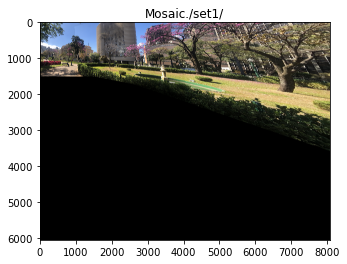

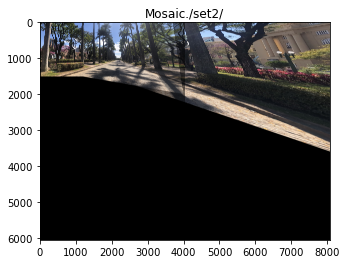

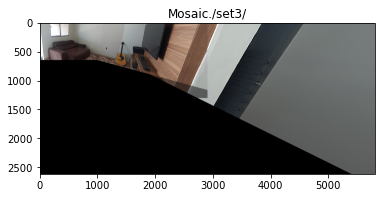

In [6]:
#Primeiro Teste: SIFT + SIFT e blend average
for sett in np.arange(1,4):
    
    dataset = './set' + str(sett) + '/'
    files = os.listdir(dataset)
    a = 2 #valor para redução da imagem
    src_file = files[0]
    #Recupera a imagem e realiza redução
    src_img = cv.imread(dataset + src_file)
    src_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)
    src_w,src_h,_ = src_img.shape
    src_w = int(src_w/a)
    src_h = int(src_h/a)
    src_img = cv.resize(src_img,(int(src_h), int(src_w)))
    
    files.remove(files[0])
    
    while len(files) != 0:
        for j, dst_file in enumerate(files):
            
            #recupera a imagem e realiza a redução
            dst_img = cv.imread(dataset + dst_file)
            dst_img = cv.cvtColor(dst_img,cv.COLOR_BGR2RGB)
            dst_w,dst_h,_ = dst_img.shape
            dst_w = int(dst_w/a)
            dst_h = int(dst_h/a)
            dst_img = cv.resize(dst_img,(int(dst_h), int(dst_w)))
            
            #extração dos keypoints da imagem 1
            src_kp, src_des = extractsift(src_img)
            #extração dos keypoints da imagem 1
            dst_kp, dst_des = extractsift(dst_img)
            
            #realiza o match retornando os pontos com melhor correspondência
            good = []
            good = matches(src_des, dst_des)
            
            #Realiza a homografia da imagem 1 com a 2  retornando a matriz M
            M, _ = homografy(good, src_kp, dst_kp)
            
            #retorna o warp e o blind da imagem 1 com a 2
            src_img = warp(dst_img, src_img, M, 1)
            
            #remove a imagem executada
            files.remove(dst_file)
                        
    plt.figure() 
    plt.title('Mosaic' + dataset)
    plt.imshow(src_img)
    plt.show()           
            

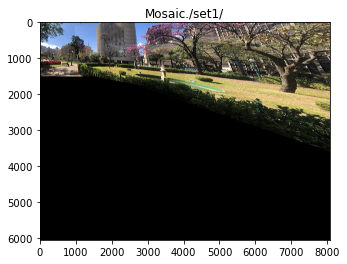

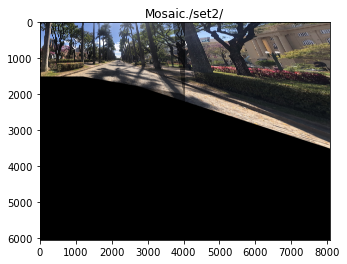

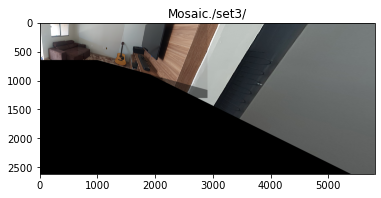

In [8]:
#Segundo Teste: SIFT + SIFT e blend Feathering
for sett in np.arange(1,4):
    
    dataset = './set' + str(sett) + '/'
    files = os.listdir(dataset)
    a = 2 #valor para redução da imagem
    src_file = files[0]
    #Recupera a imagem e realiza redução
    src_img = cv.imread(dataset + src_file)
    src_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)
    src_w,src_h,_ = src_img.shape
    src_w = int(src_w/a)
    src_h = int(src_h/a)
    src_img = cv.resize(src_img,(int(src_h), int(src_w)))
    
    files.remove(files[0])
    
    while len(files) != 0:
        for j, dst_file in enumerate(files):
            
            #recupera a imagem e realiza a redução
            dst_img = cv.imread(dataset + dst_file)
            dst_img = cv.cvtColor(dst_img,cv.COLOR_BGR2RGB)
            dst_w,dst_h,_ = dst_img.shape
            dst_w = int(dst_w/a)
            dst_h = int(dst_h/a)
            dst_img = cv.resize(dst_img,(int(dst_h), int(dst_w)))
            
            #extração dos keypoints da imagem 1
            src_kp, src_des = extractsift(src_img)
            #extração dos keypoints da imagem 1
            dst_kp, dst_des = extractsift(dst_img)
            
            #realiza o match retornando os pontos com melhor correspondência
            good = []
            good = matches(src_des, dst_des)
            
            #Realiza a homografia da imagem 1 com a 2  retornando a matriz M
            M, _ = homografy(good, src_kp, dst_kp)
            
            #retorna o warp e o blind da imagem 1 com a 2
            src_img = warp(dst_img, src_img, M, 2)
            
            #remove a imagem executada
            files.remove(dst_file)
                        
    plt.figure() 
    plt.title('Mosaic' + dataset)
    plt.imshow(src_img)
    plt.show()           
            

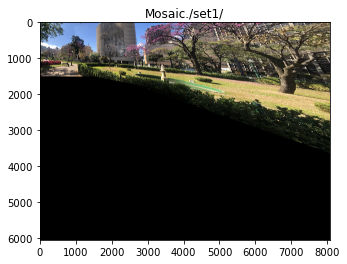

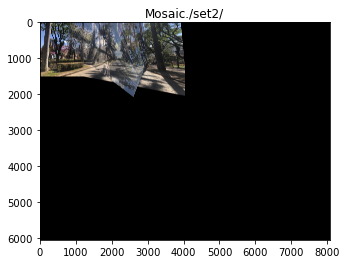

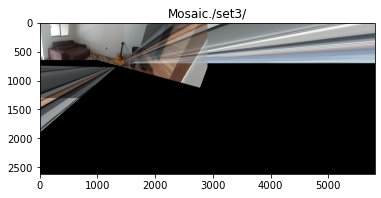

In [9]:
#Terceiro Teste: SIFT + Brief e blend average
for sett in np.arange(1,4):
    
    dataset = './set' + str(sett) + '/'
    files = os.listdir(dataset)
    a = 2 #valor para redução da imagem
    src_file = files[0]
    #Recupera a imagem e realiza redução
    src_img = cv.imread(dataset + src_file)
    src_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)
    src_w,src_h,_ = src_img.shape
    src_w = int(src_w/a)
    src_h = int(src_h/a)
    src_img = cv.resize(src_img,(int(src_h), int(src_w)))
    
    files.remove(files[0])
    
    while len(files) != 0:
        for j, dst_file in enumerate(files):
            
            #recupera a imagem e realiza a redução
            dst_img = cv.imread(dataset + dst_file)
            dst_img = cv.cvtColor(dst_img,cv.COLOR_BGR2RGB)
            dst_w,dst_h,_ = dst_img.shape
            dst_w = int(dst_w/a)
            dst_h = int(dst_h/a)
            dst_img = cv.resize(dst_img,(int(dst_h), int(dst_w)))
            
            #extração dos keypoints da imagem 1
            src_kp, src_des = extractbrief(src_img)
            #extração dos keypoints da imagem 1
            dst_kp, dst_des = extractbrief(dst_img)
            
            #realiza o match retornando os pontos com melhor correspondência
            good = []
            good = matches(src_des, dst_des)
            
            #Realiza a homografia da imagem 1 com a 2  retornando a matriz M
            M, _ = homografy(good, src_kp, dst_kp)
            
            #retorna o warp e o blind da imagem 1 com a 2
            src_img = warp(dst_img, src_img, M, 1)
            
            #remove a imagem executada
            files.remove(dst_file)
                        
    plt.figure() 
    plt.title('Mosaic' + dataset)
    plt.imshow(src_img)
    plt.show()           

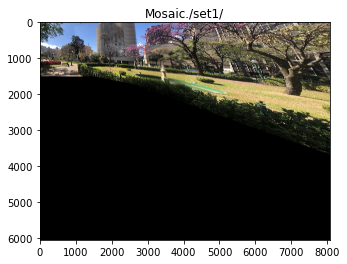

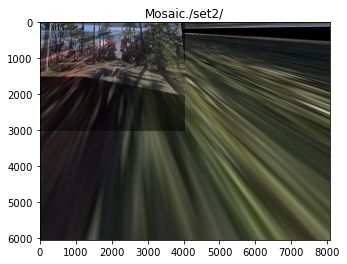

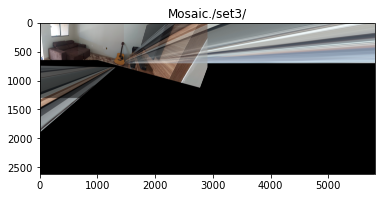

In [10]:
#Terceiro Teste: SIFT + Brief e blend Feathering
for sett in np.arange(1,4):
    
    dataset = './set' + str(sett) + '/'
    files = os.listdir(dataset)
    a = 2 #valor para redução da imagem
    src_file = files[0]
    #Recupera a imagem e realiza redução
    src_img = cv.imread(dataset + src_file)
    src_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)
    src_w,src_h,_ = src_img.shape
    src_w = int(src_w/a)
    src_h = int(src_h/a)
    src_img = cv.resize(src_img,(int(src_h), int(src_w)))
    
    files.remove(files[0])
    
    while len(files) != 0:
        for j, dst_file in enumerate(files):
            
            #recupera a imagem e realiza a redução
            dst_img = cv.imread(dataset + dst_file)
            dst_img = cv.cvtColor(dst_img,cv.COLOR_BGR2RGB)
            dst_w,dst_h,_ = dst_img.shape
            dst_w = int(dst_w/a)
            dst_h = int(dst_h/a)
            dst_img = cv.resize(dst_img,(int(dst_h), int(dst_w)))
            
            #extração dos keypoints da imagem 1
            src_kp, src_des = extractbrief(src_img)
            #extração dos keypoints da imagem 1
            dst_kp, dst_des = extractbrief(dst_img)
            
            #realiza o match retornando os pontos com melhor correspondência
            good = []
            good = matches(src_des, dst_des)
            
            #Realiza a homografia da imagem 1 com a 2  retornando a matriz M
            M, _ = homografy(good, src_kp, dst_kp)
            
            #retorna o warp e o blind da imagem 1 com a 2
            src_img = warp(dst_img, src_img, M, 2)
            
            #remove a imagem executada
            files.remove(dst_file)
                        
    plt.figure() 
    plt.title('Mosaic' + dataset)
    plt.imshow(src_img)
    plt.show()           

Resultado: 

Utilizando o Sift + Sift obteve melhores resultados comparando com o Sift + Brief, podendo ser visualizados nas saídas das imagens de cada teste realizado. 

Em comparação com a utilização do blend, conforme as imagens de saída, a percepção que os resultados foram iguais para ambos. 
